In [1]:
import os

project_root = "/Users/nimisha/Desktop/learning/news-reliability-detector/"
os.chdir(project_root)

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier
import matplotlib.pyplot as plt

from src.utils.precision_recall_chart import plot_precision_recall_curve
from src.utils.roc_curve import plot_roc_curve
from src.preprocessing.tokenization import tokenize_data
from src.utils.confusion_matrix import plot_confusion_matrix, get_confusion_matrix
from src.utils.evaluator import evaluate_model

plt.style.use("ggplot")

In [3]:
spark = SparkSession.builder.appName("RandomForest").getOrCreate()

24/01/13 18:55:53 WARN Utils: Your hostname, centella.local resolves to a loopback address: 127.0.0.1; using 192.168.1.71 instead (on interface en0)
24/01/13 18:55:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/13 18:55:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
train_transformed, test_transformed = tokenize_data(spark)

In [5]:
feature_column = "features_vector"
target_column = "target"

# Model Training

In [6]:
rf = RandomForestClassifier(
    featuresCol=feature_column, labelCol=target_column, predictionCol="prediction"
)

In [7]:
rf_model = rf.fit(train_transformed)

# Make Prediction

In [8]:
training_predictions = rf_model.transform(train_transformed)
test_predictions = rf_model.transform(test_transformed)

# Model Evaluation

### ROC curve

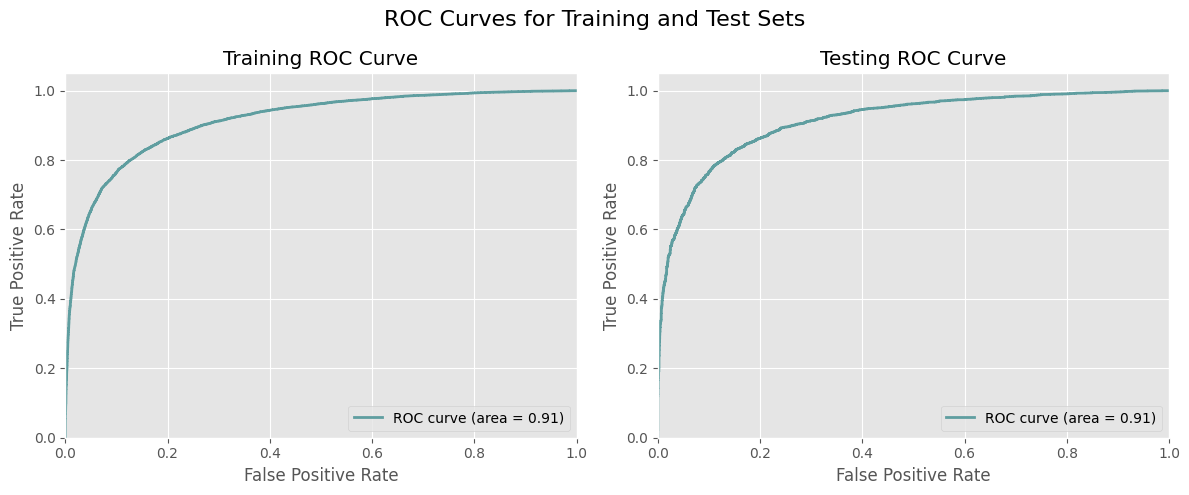

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle("ROC Curves for Training and Test Sets", fontsize=16)

plot_roc_curve(axes[0], training_predictions, target_column, "Training")
plot_roc_curve(axes[1], test_predictions, target_column, "Testing")

plt.tight_layout()
plt.show()

### Precision Recall Curve

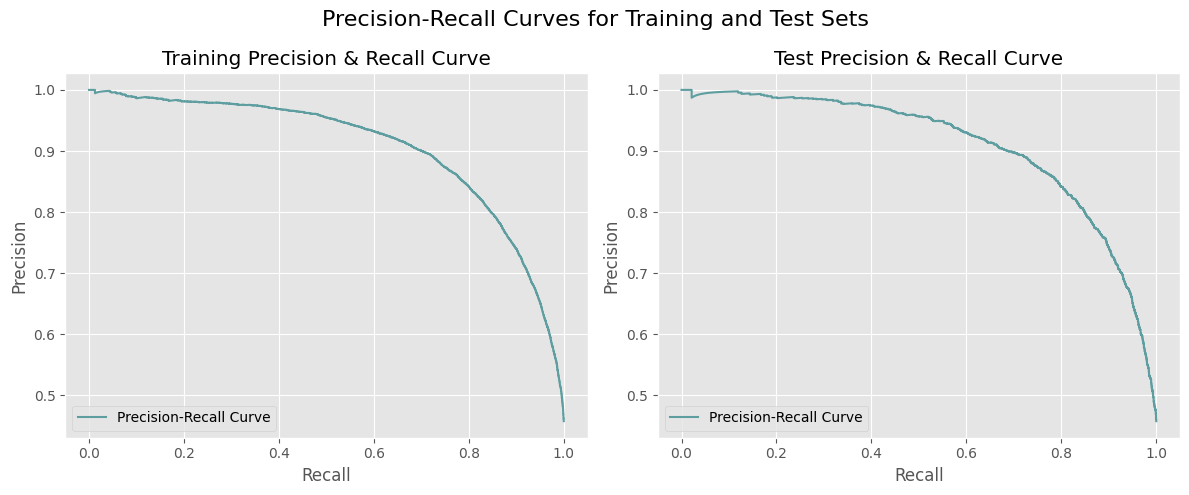

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle("Precision-Recall Curves for Training and Test Sets", fontsize=16)

plot_precision_recall_curve(axes[0], training_predictions, "target", "Training")
plot_precision_recall_curve(axes[1], test_predictions, "target", "Test")


plt.tight_layout()
plt.show()

In [11]:
train_precision, train_recall, train_accuracy = evaluate_model(
    training_predictions, "target"
)
test_precision, test_recall, test_accuracy = evaluate_model(test_predictions, "target")

table_data = [
    ["Metric", "Training Set", "Test Set"],
    ["Precision", train_precision, test_precision],
    ["Recall", train_recall, test_recall],
    ["Accuracy", train_accuracy, test_accuracy],
]

for row in table_data:
    print("{:<15} {:<20} {:<20}".format(*row))

Metric          Training Set         Test Set            
Precision       0.8410682640565134   0.8405270048087112  
Recall          0.8324045605944146   0.8317685866531337  
Accuracy        0.8324045605944146   0.8317685866531337  


In [12]:
train_confusion_matrix = get_confusion_matrix(training_predictions, "target")
test_confusion_matrix = get_confusion_matrix(test_predictions, "target")

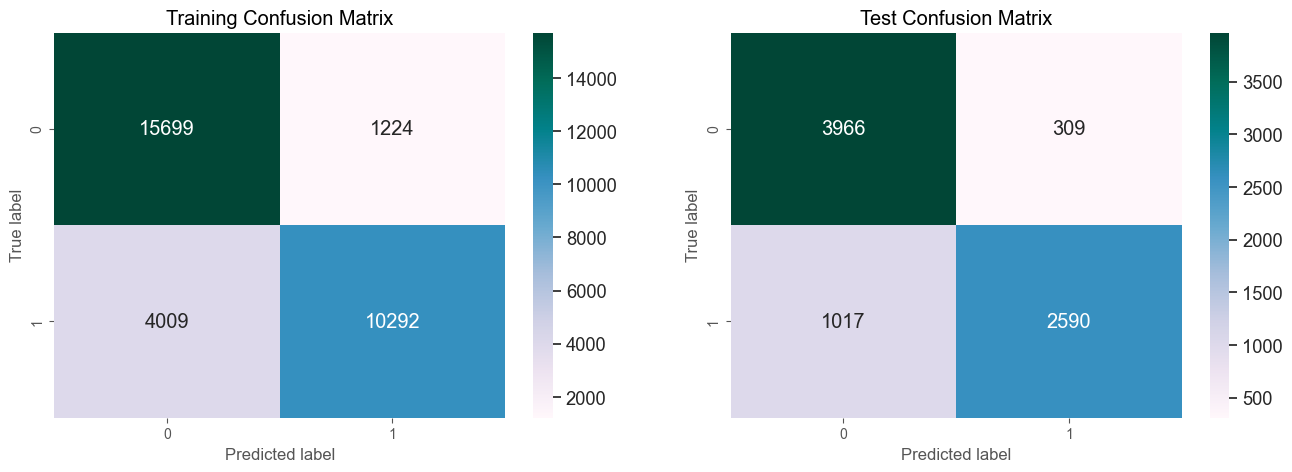

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

classes = [str(label) for label in range(2)]

plot_confusion_matrix(
    axes[0], train_confusion_matrix, classes, "Training Confusion Matrix"
)
plot_confusion_matrix(axes[1], test_confusion_matrix, classes, "Test Confusion Matrix")

# Save Model

In [15]:
rf_model.save("models/random_forest")